Image segmentation with CAMVID

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08159.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05010.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08580.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00720_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07560_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008760_P.png')]

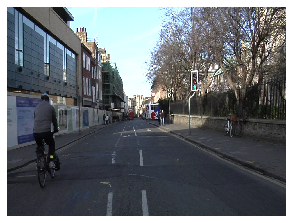

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
# convert image file names to equivalent label file names
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

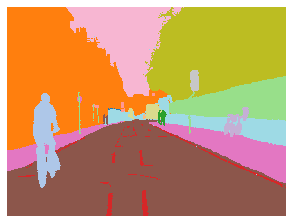

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [0]:

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

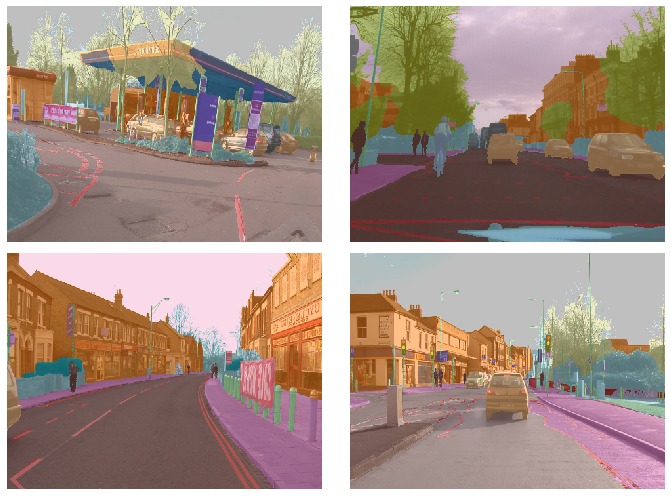

In [16]:
data.show_batch(2, figsize=(10,7))

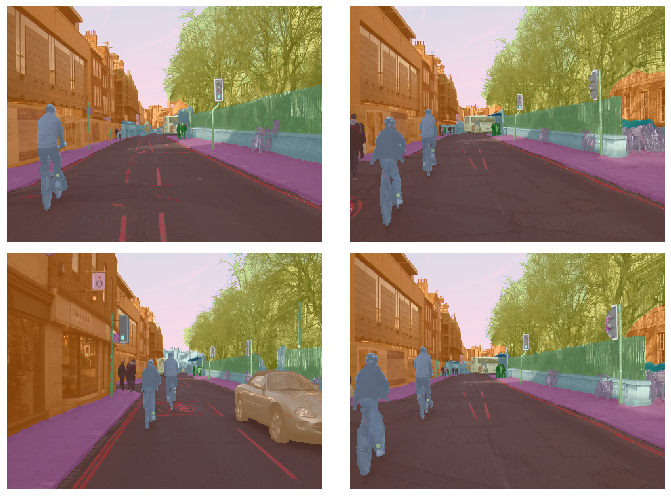

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

Modelling

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 328MB/s]


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


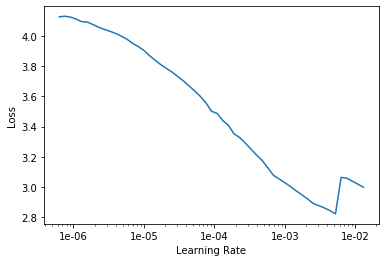

In [22]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.196258,0.769203,0.827455,00:54
1,0.818703,0.693821,0.826269,00:51
2,0.722321,0.534580,0.856703,00:51
3,0.634283,0.617080,0.850598,00:51
4,0.629293,0.527589,0.858258,00:51
5,0.582632,0.510770,0.871061,00:51
6,0.636059,0.532386,0.857269,00:51
7,0.674969,0.444165,0.872903,00:51
8,0.575881,0.645875,0.839219,00:51
9,0.489502,0.363996,0.895137,00:51


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

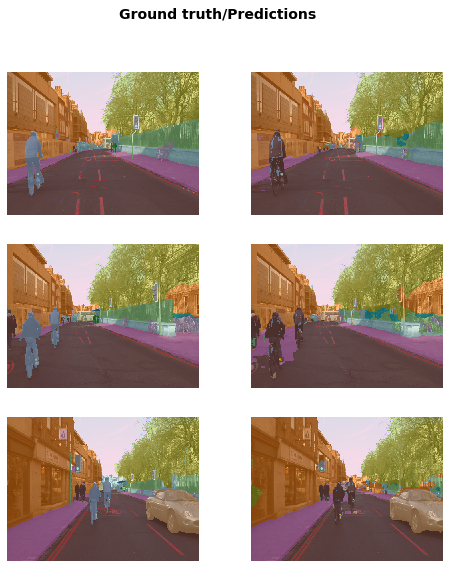

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.418384,0.350688,0.897273,00:53
1,0.406504,0.350110,0.895977,00:52
2,0.394534,0.334460,0.906691,00:52
3,0.381445,0.317356,0.907634,00:52
4,0.366837,0.315390,0.911705,00:53
5,0.353838,0.299530,0.918435,00:53
6,0.347749,0.296001,0.914528,00:53
7,0.330103,0.309215,0.910542,00:53
8,0.322873,0.292945,0.912567,00:53
9,0.314060,0.287867,0.922294,00:53


In [0]:
learn.save('stage-2');

In [32]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15565MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


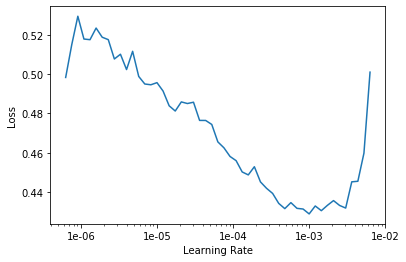

In [36]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [38]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.373758,0.313761,0.915802,03:38
1,0.336631,0.314733,0.914408,03:35
2,0.333394,0.287228,0.921204,03:35
3,0.343204,0.303790,0.913903,03:35
4,0.341679,0.291435,0.922916,03:35
5,0.344433,0.350833,0.911346,03:35
6,0.328087,0.298650,0.916003,03:35
7,0.318760,0.306280,0.920618,03:35
8,0.278263,0.275225,0.932161,03:35
9,0.240248,0.240807,0.934117,03:35


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [43]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.224188,0.246791,0.934003,03:42
1,0.213088,0.256830,0.932385,03:41
2,0.218712,0.234583,0.936125,03:41
3,0.218922,0.249010,0.932935,03:42
4,0.219142,0.230402,0.937171,03:41
5,0.204338,0.242721,0.935733,03:42
6,0.196909,0.241375,0.936009,03:42
7,0.199717,0.235098,0.937353,03:42
8,0.191846,0.234249,0.937417,03:42
9,0.193807,0.240966,0.936277,03:42


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

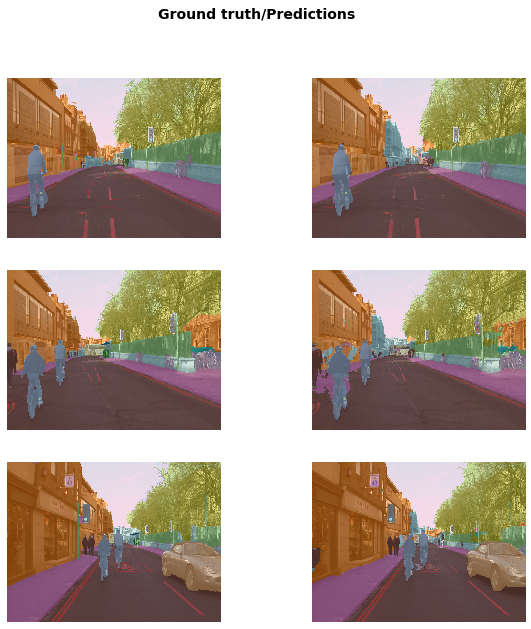

In [46]:
learn.show_results(rows=3, figsize=(10,10))